In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

In [4]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)
        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        
        V_output=V_output.transpose(0,1)
        output=[]

        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)

class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):

        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 10)
        self.final_layer=self.final_layer.float()

    def forward(self,input):

        x=self.Qnn(input)
        x=torch.flatten(x, start_dim=1)
        
        return self.final_layer(x)

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

#train_mask = np.isin(y_train, [1, 7])
#X_train, y_train = X_train[train_mask], y_train[train_mask]

#test_mask = np.isin(y_test, [1, 7])
#X_test, y_test = X_test[test_mask], y_test[test_mask]

# X_train = X_train.reshape(X_train.shape[0], 4, 16)
# X_test = X_test.reshape(X_test.shape[0], 4, 16)

In [7]:
X_train.shape

(1347, 8, 8)

In [8]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

2024-09-30 15:44:44.093973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 15:44:44.094914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 15:44:44.098628: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 15:44:44.117510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:44:44.142483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [9]:
# 4x4 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [10]:
# 각 이미지를 4x4 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [11]:
# (283, 16, 2, 2)를 (283, 16, 4)로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [12]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [13]:
X_train.shape

(1347, 4, 16)

In [14]:
X_train

array([[[ 0.,  0.,  6., ...,  0.,  3., 15.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  6., 16.],
        [10.,  0.,  0., ..., 16., 16., 12.]],

       [[ 0.,  0.,  0., ...,  0.,  8., 16.],
        [13., 13.,  0., ...,  5.,  0.,  0.],
        [ 0.,  3., 15., ...,  0.,  0.,  4.],
        [16.,  4.,  0., ..., 12.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  6., 16.,  2.],
        [10.,  0.,  0., ..., 16., 11.,  0.],
        [ 0.,  9., 14., ...,  0.,  0., 12.],
        [16., 15.,  6., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  5., ...,  0.,  9., 16.],
        [13.,  8.,  0., ..., 15.,  0.,  0.],
        [ 0.,  0., 10., ...,  0.,  7., 15.],
        [14., 14.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0., 16., 12.],
        [15.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  3., 16., ...,  0.,  1., 13.],
        [16., 10.,  1., ..., 16., 10.,  0.]],

       [[ 0.,  1.,  9., ...,  0.,  0., 15.],
        [13.,  4.,  0., ...,  1.

In [15]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [16]:
model=QSANN_text_classifier(4, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [17]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

794


In [19]:
criterion = torch.nn.CrossEntropyLoss()

In [20]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [21]:
torch.tensor(X_train)

tensor([[[ 0.,  0.,  6.,  ...,  0.,  3., 15.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  6., 16.],
         [10.,  0.,  0.,  ..., 16., 16., 12.]],

        [[ 0.,  0.,  0.,  ...,  0.,  8., 16.],
         [13., 13.,  0.,  ...,  5.,  0.,  0.],
         [ 0.,  3., 15.,  ...,  0.,  0.,  4.],
         [16.,  4.,  0.,  ..., 12.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  6., 16.,  2.],
         [10.,  0.,  0.,  ..., 16., 11.,  0.],
         [ 0.,  9., 14.,  ...,  0.,  0., 12.],
         [16., 15.,  6.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  5.,  ...,  0.,  9., 16.],
         [13.,  8.,  0.,  ..., 15.,  0.,  0.],
         [ 0.,  0., 10.,  ...,  0.,  7., 15.],
         [14., 14.,  0.,  ..., 10.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0., 16., 12.],
         [15.,  1.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  3., 16.,  ...,  0.,  1., 13.],
         [16., 10.,  1.,  ..., 16., 10.,  0.]],

        [[ 0.,  1.,  9.,  ...,  0., 

  0%|          | 0/30 [00:00<?, ?it/s]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9938, 0.9999, 0.9878, 0.7890],
         [0.8753, 0.9150, 0.9698, 0.5504],
         [0.9265, 0.9571, 0.9925, 0.6263],
         [0.9251, 0.8873, 0.8027, 0.9836]],

        [[0.9970, 0.8609, 0.9955, 0.8076],
         [0.8224, 1.0000, 0.9025, 0.9944],
         [0.9832, 0.7210, 0.9384, 0.6578],
         [0.8081, 0.4422, 0.7115, 0.3838]],

        [[0.9832, 0.9968, 0.9670, 0.9907],
         [0.9905, 0.9711, 0.9980, 0.9828],
         [0.7704, 0.8260, 0.7278, 0.7966],
         [0.9998, 0.9927, 0.9984, 0.9979]],

        ...,

        [[0.7220, 0.8002, 0.7346, 0.7379],
         [0.8348, 0.7603, 0.8238, 0.8208],
         [0.8984, 0.8342, 0.8892, 0.8868],
         [0.9976, 0.9785, 0.9959, 0.9954]],

        [[1.0000, 0.9897, 0.9999, 0.9618],
         [0.9884, 1.0000, 0.9871, 0.9914],
         [0.8489, 0.7708, 0.8527, 0.6926],
         [0.9998, 0.9858, 0.9999, 0.9547]],

        [[0.9213, 0.5904, 0.9703, 0.9878],
         [0.9135, 0.5781, 0.9652, 0.9844],
         [0.9961, 0.776

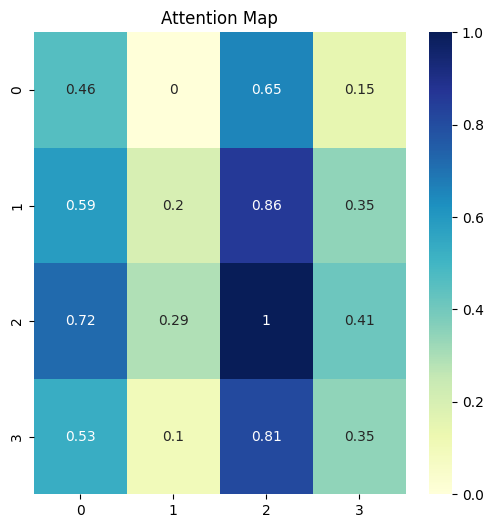

tensor([2, 1, 1,  ..., 8, 8, 2])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.1329)

tensor(5.3620, grad_fn=<DivBackward1>)


  3%|▎         | 1/30 [07:10<3:28:07, 430.60s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9360, 0.8857, 0.9557, 0.9211],
         [0.9986, 0.9836, 1.0000, 0.7738],
         [0.9798, 0.9466, 0.9903, 0.8516],
         [0.7473, 0.6715, 0.7822, 1.0000]],

        [[0.9976, 0.7977, 0.9930, 0.8700],
         [0.9961, 0.8765, 0.9623, 0.9342],
         [0.9504, 0.9607, 0.8792, 0.9904],
         [0.7822, 0.4278, 0.8769, 0.5111]],

        [[0.9979, 0.9946, 0.9611, 0.9898],
         [0.9803, 0.9996, 0.9173, 1.0000],
         [0.7354, 0.6343, 0.8511, 0.6110],
         [0.9740, 0.9982, 0.9055, 0.9998]],

        ...,

        [[0.7246, 0.7155, 0.7516, 0.8268],
         [0.9883, 0.9905, 0.9801, 0.9441],
         [0.9437, 0.9486, 0.9277, 0.8707],
         [0.9999, 0.9996, 0.9994, 0.9850]],

        [[0.9998, 0.9276, 0.9766, 0.9834],
         [0.8884, 0.9969, 0.9696, 0.8102],
         [0.8943, 0.9979, 0.9729, 0.8174],
         [0.9993, 0.9058, 0.9629, 0.9921]],

        [[0.9868, 0.7468, 0.9999, 0.9956],
         [0.9999, 0.8427, 0.9869, 0.9964],
         [0.9761, 0.713

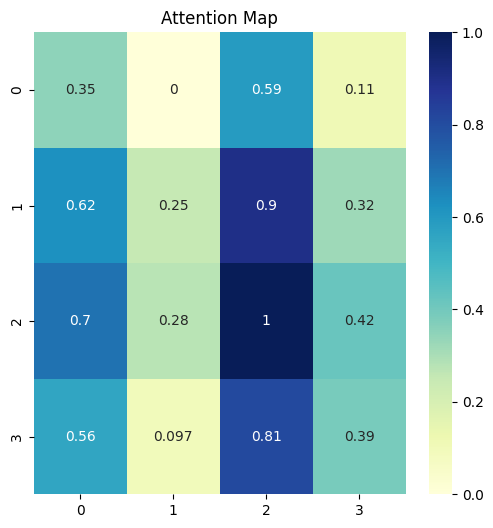

tensor([6, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.2331)

tensor(3.6472, grad_fn=<DivBackward1>)


  7%|▋         | 2/30 [15:45<3:43:57, 479.92s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9913, 0.9286, 0.9830, 0.7837],
         [0.9613, 0.9726, 0.9993, 0.6985],
         [0.9032, 0.9979, 0.9911, 0.5958],
         [0.5141, 0.8165, 0.7049, 0.2279]],

        [[0.9976, 0.8490, 0.9899, 0.8286],
         [0.9731, 0.9643, 0.9056, 0.6574],
         [0.8960, 0.6237, 0.9675, 0.9774],
         [0.7664, 0.4679, 0.8746, 0.9989]],

        [[0.9915, 0.9936, 0.9943, 0.9943],
         [0.9992, 0.9998, 0.9806, 0.9999],
         [0.6347, 0.6451, 0.7737, 0.6491],
         [0.9949, 0.9965, 0.9908, 0.9970]],

        ...,

        [[0.5211, 0.7818, 0.7349, 0.7765],
         [0.6991, 0.9208, 0.8872, 0.9172],
         [0.7977, 0.9734, 0.9515, 0.9712],
         [0.9101, 1.0000, 0.9970, 1.0000]],

        [[1.0000, 0.9284, 0.9950, 0.9976],
         [0.9745, 0.9888, 0.9454, 0.9863],
         [0.8362, 0.9759, 0.7793, 0.8657],
         [0.9955, 0.8946, 0.9999, 0.9880]],

        [[0.9997, 0.8511, 0.9967, 0.9998],
         [0.9503, 0.9755, 0.9658, 0.9348],
         [0.9930, 0.914

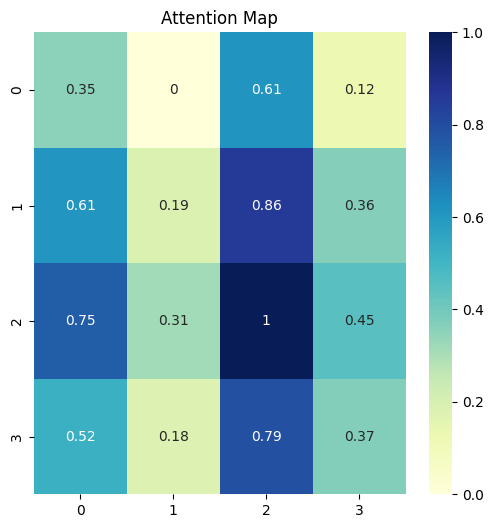

tensor([9, 1, 4,  ..., 8, 9, 5])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.2413)

tensor(3.1523, grad_fn=<DivBackward1>)


 10%|█         | 3/30 [24:55<3:50:22, 511.95s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9201, 0.9970, 0.9559, 0.6797],
         [0.9839, 0.9888, 0.9974, 0.5420],
         [0.9989, 0.9607, 0.9982, 0.4638],
         [0.7162, 0.8884, 0.7776, 0.8955]],

        [[0.9969, 0.8786, 0.9937, 0.8093],
         [0.8766, 0.9972, 0.8614, 0.9769],
         [0.9350, 0.9759, 0.9232, 0.9363],
         [0.8755, 0.5440, 0.8901, 0.4605]],

        [[0.9973, 1.0000, 0.9978, 0.9931],
         [0.9982, 0.9910, 0.9805, 0.9999],
         [0.9476, 0.9684, 0.9823, 0.9330],
         [0.9740, 0.9548, 0.9344, 0.9830]],

        ...,

        [[0.9399, 0.6666, 0.7742, 0.8439],
         [0.9807, 0.7572, 0.8546, 0.9126],
         [0.9997, 0.8495, 0.9282, 0.9685],
         [0.9312, 0.9855, 0.9999, 0.9892]],

        [[1.0000, 0.9863, 0.9768, 0.9995],
         [0.9407, 0.9840, 0.9917, 0.9309],
         [0.8300, 0.7374, 0.7080, 0.8444],
         [0.9188, 0.8443, 0.8189, 0.9294]],

        [[0.9829, 0.9998, 0.9816, 0.9820],
         [0.9597, 0.9030, 0.9615, 0.9609],
         [0.9982, 0.994

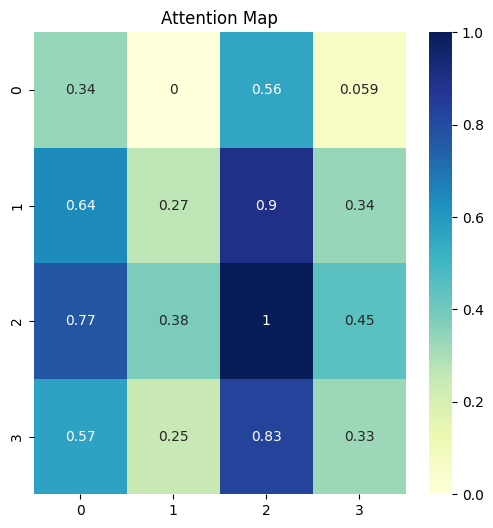

tensor([2, 1, 4,  ..., 8, 6, 5])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.3222)

tensor(2.7117, grad_fn=<DivBackward1>)


 13%|█▎        | 4/30 [33:55<3:46:47, 523.37s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9987, 0.8982, 0.9562, 0.5017],
         [0.8437, 0.9977, 0.9733, 0.8133],
         [0.9798, 0.9523, 0.9891, 0.5921],
         [0.6131, 0.8936, 0.8155, 0.9724]],

        [[0.9998, 0.7932, 0.9998, 0.8269],
         [0.9867, 0.6881, 0.9794, 0.9107],
         [0.9934, 0.7166, 0.9880, 0.8908],
         [0.8094, 0.9987, 0.8302, 0.4598]],

        [[0.9947, 0.9962, 0.8819, 0.9987],
         [0.9771, 0.9737, 0.9833, 0.9651],
         [0.8315, 0.8395, 0.6028, 0.8568],
         [0.9963, 0.9948, 0.9523, 0.9906]],

        ...,

        [[0.6271, 0.7467, 0.7989, 0.7245],
         [0.9990, 0.9701, 0.9437, 0.9787],
         [0.9995, 0.9729, 0.9475, 0.9810],
         [0.9723, 0.9994, 0.9983, 0.9973]],

        [[0.9981, 0.9867, 0.9971, 0.9846],
         [0.9247, 0.9855, 0.9672, 0.9875],
         [0.8090, 0.6815, 0.7326, 0.6739],
         [0.9996, 0.9683, 0.9862, 0.9651]],

        [[0.9823, 0.9432, 0.9814, 0.9582],
         [0.9780, 0.9501, 0.9770, 0.9519],
         [0.9972, 0.832

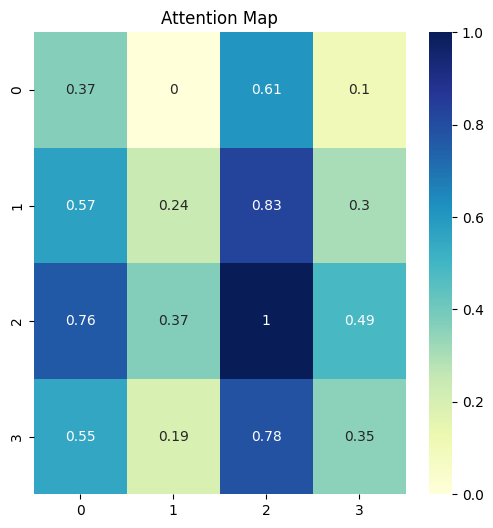

tensor([2, 1, 4,  ..., 8, 6, 5])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.4336)

tensor(2.1570, grad_fn=<DivBackward1>)


 17%|█▋        | 5/30 [42:55<3:40:28, 529.13s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9975, 1.0000, 0.9787, 0.7553],
         [0.9884, 0.9756, 0.9999, 0.6229],
         [0.9999, 0.9967, 0.9924, 0.7071],
         [0.6819, 0.6401, 0.7610, 0.2376]],

        [[0.9997, 0.8906, 0.9997, 0.7672],
         [0.9904, 0.8374, 0.9960, 0.8284],
         [0.9472, 0.7344, 0.9617, 0.9142],
         [0.7549, 0.4830, 0.7827, 1.0000]],

        [[0.9689, 0.9980, 0.8752, 0.9924],
         [0.9897, 0.9465, 0.9927, 0.9638],
         [0.6016, 0.7141, 0.4446, 0.6785],
         [0.9657, 0.9971, 0.8693, 0.9907]],

        ...,

        [[0.8642, 0.6734, 0.7772, 0.8530],
         [0.9517, 0.8023, 0.8892, 0.9444],
         [0.7200, 0.8990, 0.8144, 0.7337],
         [0.9902, 0.9785, 0.9996, 0.9932]],

        [[0.9990, 0.9264, 0.9937, 0.9863],
         [0.9525, 0.9923, 0.9305, 0.9949],
         [0.7822, 0.5239, 0.8182, 0.6596],
         [0.9645, 0.7799, 0.9799, 0.8911]],

        [[0.9889, 0.8284, 0.9806, 0.9940],
         [0.9851, 0.8404, 0.9757, 0.9910],
         [0.9929, 0.677

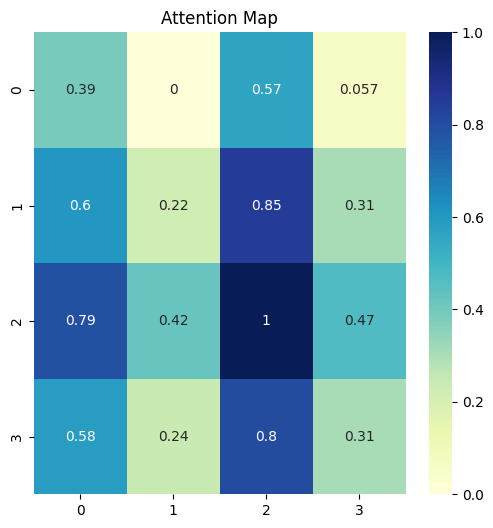

tensor([2, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.5375)

tensor(1.6328, grad_fn=<DivBackward1>)


 20%|██        | 6/30 [52:05<3:34:34, 536.44s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8686, 0.9980, 0.9633, 0.7946],
         [0.9962, 0.9302, 0.9856, 0.5329],
         [0.9858, 0.9566, 0.9961, 0.5825],
         [0.6763, 0.9167, 0.8214, 0.9487]],

        [[0.9971, 0.8041, 0.9884, 0.7996],
         [0.9532, 0.6708, 0.9968, 0.6657],
         [0.9767, 0.7255, 0.9999, 0.7205],
         [0.7880, 0.4440, 0.8991, 0.4392]],

        [[0.9716, 0.9975, 0.9707, 0.9973],
         [0.9221, 0.9731, 0.9208, 0.9724],
         [0.5337, 0.6360, 0.5316, 0.6342],
         [0.9600, 0.9932, 0.9590, 0.9929]],

        ...,

        [[0.5316, 0.8448, 0.7266, 0.6733],
         [0.9595, 0.7080, 0.8289, 0.8725],
         [0.9986, 0.8868, 0.9638, 0.9837],
         [0.9098, 0.9941, 0.9940, 0.9802]],

        [[0.9984, 0.9240, 0.9979, 0.9851],
         [0.9826, 0.8693, 0.9808, 0.9546],
         [0.9292, 0.9991, 0.9325, 0.9653],
         [0.9343, 0.7770, 0.9311, 0.8887]],

        [[1.0000, 0.9977, 0.9978, 0.9997],
         [0.9748, 0.9882, 0.9592, 0.9806],
         [1.0000, 0.997

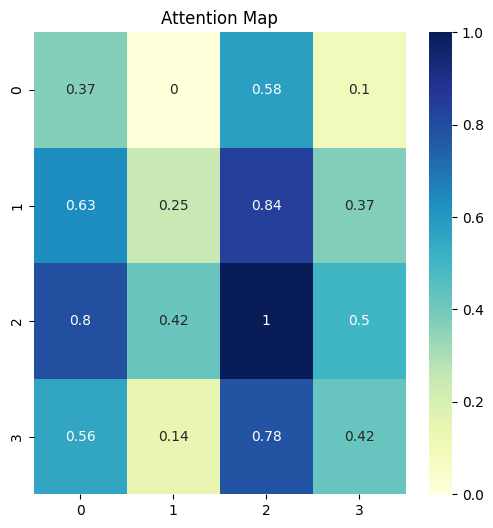

tensor([2, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.6221)

tensor(1.2772, grad_fn=<DivBackward1>)


 23%|██▎       | 7/30 [1:00:57<3:24:59, 534.78s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8991, 0.9150, 0.9813, 0.6883],
         [0.8864, 0.9031, 0.9752, 0.6704],
         [0.9391, 0.9516, 0.9962, 0.7504],
         [0.7355, 0.7581, 0.8750, 0.4944]],

        [[0.9994, 0.7756, 0.9996, 0.8046],
         [0.9878, 0.7061, 0.9888, 0.7373],
         [0.9722, 0.9077, 0.9707, 0.9280],
         [0.8109, 0.9995, 0.8075, 0.9997]],

        [[0.9997, 0.9838, 0.9520, 0.9970],
         [0.9956, 0.9557, 0.9102, 0.9807],
         [0.9820, 0.9240, 0.8689, 0.9577],
         [0.9728, 0.9996, 0.9946, 0.9913]],

        ...,

        [[0.7841, 0.7162, 0.7517, 0.8055],
         [0.8559, 0.9085, 0.8826, 0.8364],
         [0.9930, 1.0000, 0.9981, 0.9875],
         [0.9920, 1.0000, 0.9976, 0.9862]],

        [[1.0000, 0.9256, 0.9977, 0.9592],
         [0.9652, 0.8079, 0.9476, 0.9996],
         [0.8871, 0.9948, 0.9127, 0.7351],
         [0.9987, 0.9087, 0.9937, 0.9706]],

        [[0.9983, 0.8928, 1.0000, 0.9988],
         [0.9438, 0.9812, 0.9595, 0.9468],
         [0.9998, 0.856

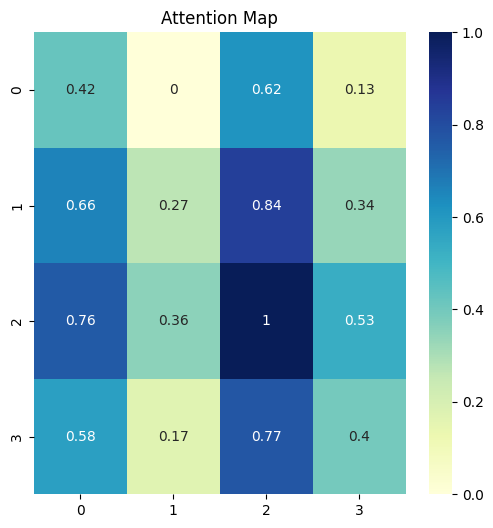

tensor([2, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.6600)

tensor(1.1117, grad_fn=<DivBackward1>)


 27%|██▋       | 8/30 [1:10:04<3:17:33, 538.78s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9433, 0.8950, 0.9685, 0.3718],
         [0.9975, 0.9802, 0.9998, 0.5245],
         [0.9811, 0.9487, 0.9943, 0.4519],
         [0.7636, 0.8327, 0.7128, 0.9468]],

        [[0.9972, 0.7851, 0.9946, 0.8742],
         [0.7307, 0.3687, 0.8286, 0.9805],
         [0.8914, 0.5461, 0.9559, 0.9935],
         [0.8339, 0.9998, 0.7368, 0.4889]],

        [[0.9985, 0.9714, 1.0000, 0.9939],
         [0.9999, 0.9857, 0.9969, 0.9992],
         [0.7065, 0.5948, 0.7426, 0.6737],
         [0.9906, 0.9988, 0.9803, 0.9966]],

        ...,

        [[0.5209, 0.7305, 0.7869, 0.7267],
         [0.8453, 0.9739, 0.9916, 0.9724],
         [0.5677, 0.7747, 0.8281, 0.7711],
         [0.9555, 0.9989, 0.9891, 0.9991]],

        [[0.9988, 0.9824, 0.9971, 0.9990],
         [0.9774, 0.9035, 0.9829, 0.9768],
         [0.8404, 0.7108, 0.8543, 0.8391],
         [0.9891, 0.9961, 0.9846, 0.9895]],

        [[0.9999, 0.9915, 1.0000, 0.9962],
         [1.0000, 0.9892, 1.0000, 0.9946],
         [0.9980, 0.978

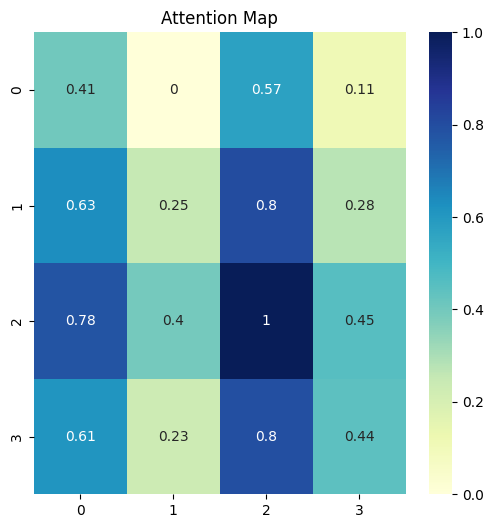

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.6800)

tensor(0.9958, grad_fn=<DivBackward1>)


 30%|███       | 9/30 [1:18:58<3:08:03, 537.31s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9856, 0.8837, 0.9612, 0.3532],
         [0.9935, 0.9073, 0.9749, 0.3824],
         [0.9717, 0.9962, 0.9918, 0.5865],
         [0.8766, 0.7024, 0.8228, 0.2030]],

        [[0.9996, 0.8822, 0.9930, 0.8123],
         [0.8270, 0.9962, 0.7793, 0.4677],
         [0.8420, 0.9984, 0.7956, 0.4850],
         [0.8088, 0.4981, 0.8541, 0.9994]],

        [[0.9817, 0.9893, 0.9476, 0.9927],
         [0.9927, 0.9971, 0.9234, 0.9987],
         [0.9155, 0.9321, 0.9950, 0.9408],
         [0.9982, 0.9944, 0.8447, 0.9914]],

        ...,

        [[0.5315, 0.6479, 0.6860, 0.8710],
         [0.9594, 0.9955, 0.9995, 0.9528],
         [0.9643, 0.8986, 0.8709, 0.6858],
         [0.9120, 0.9724, 0.9851, 0.9857]],

        [[0.9989, 0.9815, 0.9999, 0.9991],
         [0.9762, 0.8998, 0.9695, 0.9533],
         [0.8697, 0.7444, 0.8559, 0.8261],
         [0.9965, 0.9879, 0.9985, 1.0000]],

        [[0.9885, 0.7516, 0.9999, 0.9996],
         [0.9705, 0.8028, 0.9943, 0.9979],
         [0.9794, 0.780

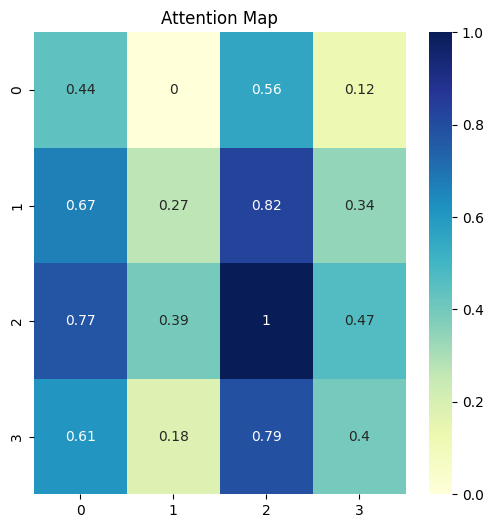

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.7201)

tensor(0.8513, grad_fn=<DivBackward1>)


 33%|███▎      | 10/30 [1:27:56<2:59:07, 537.36s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9996, 0.9999, 0.9819, 0.5397],
         [0.9193, 0.9250, 0.9820, 0.7666],
         [0.9363, 0.9415, 0.9898, 0.7397],
         [0.7155, 0.7245, 0.8360, 0.9498]],

        [[0.9996, 0.8488, 0.9997, 0.8595],
         [0.9735, 0.9525, 0.9729, 0.7199],
         [0.9615, 0.9659, 0.9608, 0.6912],
         [0.7386, 0.4173, 0.7402, 0.9804]],

        [[0.9957, 0.9865, 0.9408, 0.9953],
         [0.9683, 0.9484, 0.9823, 0.9673],
         [0.6302, 0.6735, 0.3734, 0.6326],
         [0.9981, 0.9912, 0.9299, 0.9979]],

        ...,

        [[0.7522, 0.8169, 0.8394, 0.7948],
         [0.9549, 0.9830, 0.9901, 0.9746],
         [0.9282, 0.9649, 0.9754, 0.9533],
         [0.9906, 0.9998, 0.9997, 0.9982]],

        [[0.9998, 0.9254, 0.9885, 0.9982],
         [0.9617, 0.9955, 0.9032, 0.9373],
         [0.7517, 0.9298, 0.6506, 0.7050],
         [0.9996, 0.9224, 0.9897, 0.9986]],

        [[0.9985, 0.8480, 0.9899, 0.9989],
         [0.9439, 0.9840, 0.9688, 0.9411],
         [0.9877, 0.936

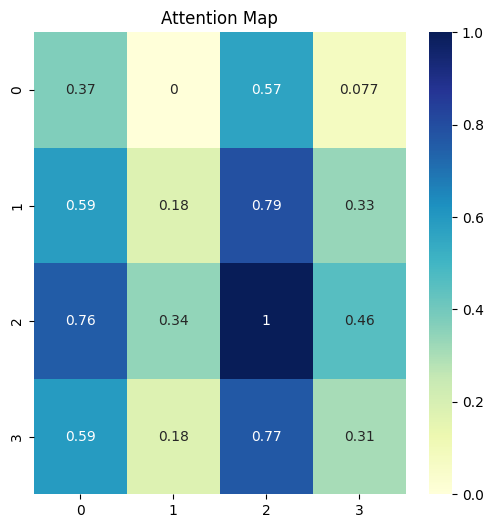

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.7684)

tensor(0.7016, grad_fn=<DivBackward1>)


 37%|███▋      | 11/30 [1:36:19<2:46:48, 526.79s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9864, 0.8801, 0.9582, 0.4741],
         [0.9983, 0.9240, 0.9831, 0.5376],
         [0.9746, 0.9936, 0.9950, 0.7089],
         [0.7384, 0.9081, 0.8085, 0.9623]],

        [[0.9972, 0.8714, 0.9942, 0.8112],
         [0.8527, 0.9994, 0.8367, 0.5242],
         [0.8880, 0.5539, 0.9018, 0.9964],
         [0.8472, 0.5011, 0.8628, 1.0000]],

        [[0.9860, 0.9684, 0.9545, 0.9960],
         [0.9957, 0.9843, 0.9301, 0.9999],
         [0.9732, 0.9892, 0.7793, 0.9528],
         [0.9669, 0.9422, 0.9774, 0.9837]],

        ...,

        [[0.8565, 0.9093, 0.7837, 0.8932],
         [0.9087, 0.8557, 0.9571, 0.8740],
         [0.9283, 0.8796, 0.9706, 0.8966],
         [0.9965, 0.9993, 0.9748, 1.0000]],

        [[0.9999, 0.9831, 0.9936, 0.9894],
         [0.9596, 0.8898, 0.9188, 0.9884],
         [0.8814, 0.7836, 0.8217, 0.9345],
         [0.9995, 0.9743, 0.9878, 0.9948]],

        [[0.9298, 0.7969, 0.9715, 0.9920],
         [0.9685, 0.9992, 0.9253, 0.8791],
         [0.9968, 0.933

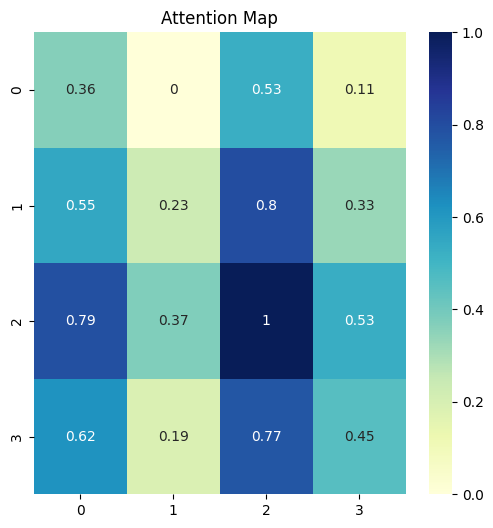

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.7996)

tensor(0.6092, grad_fn=<DivBackward1>)


 40%|████      | 12/30 [1:44:13<2:33:18, 511.02s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9973, 0.9997, 0.9830, 0.6257],
         [0.9961, 0.9830, 0.9997, 0.5278],
         [0.9684, 0.9407, 0.9901, 0.4323],
         [0.9076, 0.9426, 0.8586, 0.8345]],

        [[0.9971, 0.8770, 0.9994, 0.8107],
         [0.8691, 0.9957, 0.8496, 0.9991],
         [0.9225, 0.7039, 0.9371, 0.6225],
         [0.8329, 0.9859, 0.8116, 0.9995]],

        [[0.9997, 0.9560, 0.9722, 0.9905],
         [0.9909, 0.9198, 0.9417, 0.9699],
         [0.6789, 0.5140, 0.5513, 0.6114],
         [1.0000, 0.9638, 0.9783, 0.9940]],

        ...,

        [[0.6786, 0.8772, 0.7226, 0.7372],
         [0.9545, 0.9980, 0.9737, 0.9791],
         [0.9618, 0.9960, 0.9793, 0.9840],
         [0.9928, 0.9696, 0.9990, 0.9998]],

        [[1.0000, 0.9334, 0.9992, 0.9982],
         [0.9581, 0.9966, 0.9475, 0.9741],
         [0.9061, 0.7150, 0.9199, 0.8791],
         [0.9883, 0.8697, 0.9931, 0.9767]],

        [[0.9967, 0.9475, 0.9884, 0.9928],
         [0.9669, 0.7991, 0.9824, 0.9758],
         [1.0000, 0.917

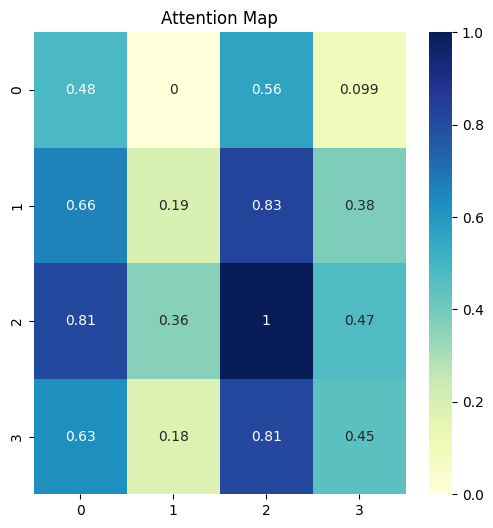

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8144)

tensor(0.5549, grad_fn=<DivBackward1>)


 43%|████▎     | 13/30 [1:52:05<2:21:26, 499.18s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9104, 0.9956, 0.9562, 0.3718],
         [0.9854, 0.9859, 0.9993, 0.5193],
         [0.9736, 0.9941, 0.9953, 0.4839],
         [0.9384, 0.7846, 0.8866, 0.8268]],

        [[0.9995, 0.8419, 0.9994, 0.8063],
         [0.8802, 0.9938, 0.8777, 0.9837],
         [0.9676, 0.6828, 0.9690, 0.6410],
         [0.8128, 0.4517, 0.8157, 0.4128]],

        [[0.9931, 0.9779, 0.8745, 0.9932],
         [0.9998, 0.9934, 0.9149, 0.9998],
         [0.8255, 0.8710, 0.9763, 0.8251],
         [0.9841, 0.9964, 0.9758, 0.9840]],

        ...,

        [[0.6438, 0.7392, 0.6910, 0.8730],
         [0.9298, 0.8631, 0.8995, 0.7268],
         [0.9064, 0.8330, 0.8726, 0.6905],
         [0.9872, 1.0000, 0.9967, 0.9675]],

        [[0.9991, 0.9809, 0.9978, 0.9796],
         [0.9636, 0.9929, 0.9695, 0.9937],
         [0.9197, 0.9676, 0.9283, 0.9694],
         [0.9779, 0.9358, 0.9728, 0.9334]],

        [[0.9748, 0.9999, 0.9812, 0.9954],
         [0.9693, 1.0000, 0.9764, 0.9928],
         [0.9995, 0.963

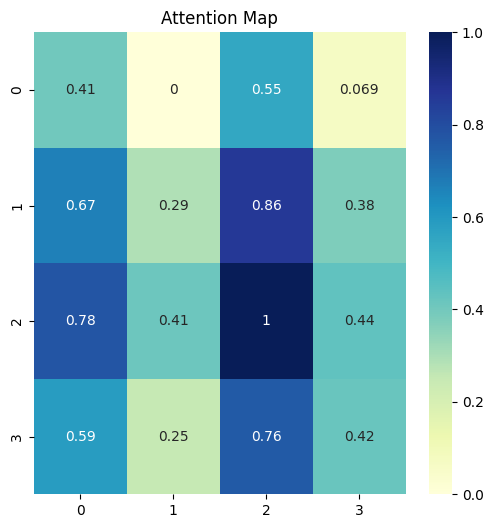

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8411)

tensor(0.4996, grad_fn=<DivBackward1>)


 47%|████▋     | 14/30 [1:59:59<2:11:01, 491.31s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9217, 0.9999, 0.9835, 0.7725],
         [0.9364, 0.9996, 0.9901, 0.7492],
         [0.9970, 0.9516, 0.9896, 0.5792],
         [0.6580, 0.8723, 0.7864, 0.9787]],

        [[0.9972, 0.7858, 0.9898, 0.7604],
         [0.9562, 0.5651, 0.8749, 0.5376],
         [0.9954, 0.6879, 0.9520, 0.6605],
         [0.7511, 0.9999, 0.8648, 0.9983]],

        [[0.9833, 0.9771, 0.9983, 0.9945],
         [0.9962, 0.9930, 0.9881, 1.0000],
         [0.9620, 0.9701, 0.8738, 0.9383],
         [0.9740, 0.9664, 0.9999, 0.9887]],

        ...,

        [[0.8370, 0.8429, 0.7968, 0.8663],
         [0.9217, 0.9261, 0.8906, 0.9429],
         [0.9749, 0.9774, 0.9551, 0.9865],
         [0.9905, 0.9888, 0.9982, 0.9804]],

        [[0.9991, 0.9353, 0.9996, 0.9870],
         [0.9560, 0.9941, 0.9603, 0.9955],
         [0.9177, 0.7128, 0.9118, 0.8257],
         [0.9150, 0.9999, 0.9207, 0.9767]],

        [[0.9727, 0.5776, 0.9718, 0.9881],
         [0.9617, 0.5511, 0.9607, 0.9805],
         [0.9976, 0.759

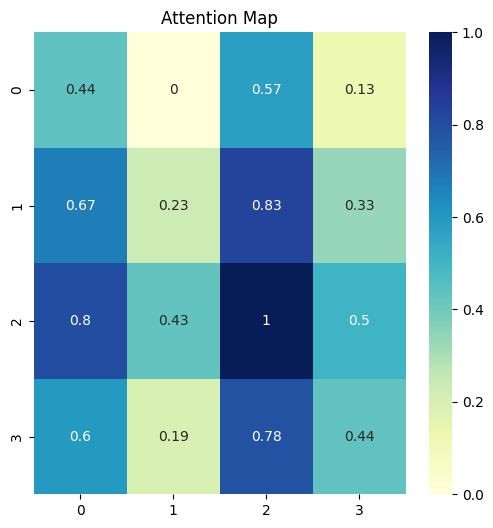

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8612)

tensor(0.4531, grad_fn=<DivBackward1>)


 50%|█████     | 15/30 [2:07:46<2:01:02, 484.15s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9210, 0.9960, 0.9661, 0.9097],
         [0.9938, 0.9794, 0.9995, 0.7665],
         [0.9755, 0.9957, 0.9968, 0.8262],
         [0.7947, 0.6104, 0.7141, 0.3157]],

        [[0.9978, 0.7808, 0.9951, 0.8136],
         [0.9546, 0.5617, 0.8957, 0.9637],
         [0.9439, 0.5407, 0.8806, 0.9723],
         [0.8305, 0.3865, 0.7411, 0.9995]],

        [[0.9967, 0.9879, 0.9983, 0.9956],
         [0.9826, 0.9661, 0.9989, 0.9802],
         [0.7829, 0.8228, 0.7031, 0.7896],
         [0.9969, 1.0000, 0.9763, 0.9978]],

        ...,

        [[0.5872, 0.7961, 0.6824, 0.8019],
         [0.7559, 0.9262, 0.8400, 0.9301],
         [0.9760, 0.8466, 0.9310, 0.8413],
         [0.9949, 0.9680, 0.9984, 0.9653]],

        [[1.0000, 0.9325, 0.9992, 0.9979],
         [0.9918, 0.9681, 0.9874, 0.9831],
         [0.7274, 0.9174, 0.7091, 0.6941],
         [0.9992, 0.9433, 0.9974, 0.9953]],

        [[0.9667, 0.8802, 0.9997, 0.9976],
         [0.9024, 0.7838, 0.9771, 0.9923],
         [0.9561, 0.862

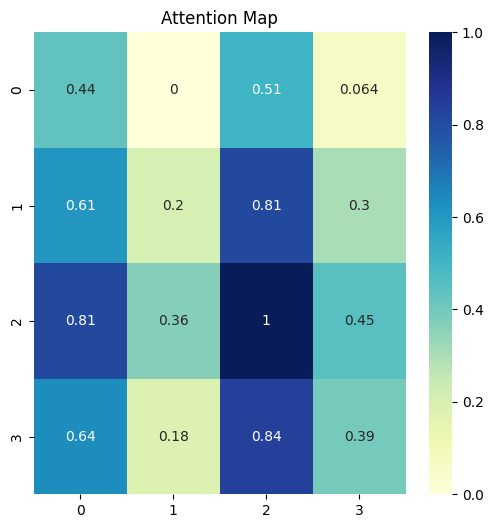

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8753)

tensor(0.4125, grad_fn=<DivBackward1>)


 53%|█████▎    | 16/30 [2:15:40<1:52:15, 481.10s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8970, 0.9229, 0.9755, 0.7852],
         [0.9670, 0.9815, 0.9999, 0.6654],
         [0.9381, 0.9583, 0.9935, 0.7238],
         [0.9413, 0.9181, 0.8397, 0.3201]],

        [[0.9979, 0.8460, 1.0000, 0.8016],
         [0.9681, 0.7449, 0.9831, 0.6943],
         [0.9435, 0.9853, 0.9190, 0.9671],
         [0.8267, 0.9946, 0.7897, 0.9999]],

        [[0.9997, 0.9943, 0.9396, 0.9943],
         [0.9937, 0.9998, 0.9080, 0.9998],
         [0.5185, 0.5983, 0.3379, 0.5988],
         [0.9987, 0.9831, 0.9629, 0.9830]],

        ...,

        [[0.6153, 0.7558, 0.7651, 0.6990],
         [0.9971, 0.9521, 0.9470, 0.9771],
         [0.8918, 0.9713, 0.9751, 0.9441],
         [0.9820, 0.9989, 0.9980, 0.9987]],

        [[0.9996, 0.9830, 0.9989, 0.9953],
         [0.9487, 0.8902, 0.9689, 0.9802],
         [0.7796, 0.6888, 0.8188, 0.8446],
         [0.9053, 0.8333, 0.9329, 0.9496]],

        [[0.9461, 0.7938, 0.9796, 0.9872],
         [0.8664, 0.6776, 0.9209, 0.9362],
         [0.9977, 0.917

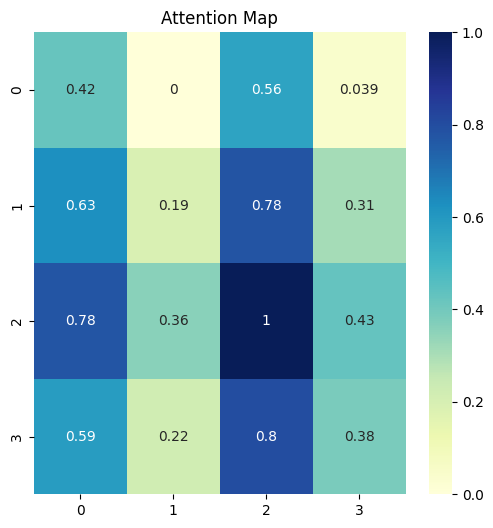

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8916)

tensor(0.3807, grad_fn=<DivBackward1>)


 57%|█████▋    | 17/30 [2:23:47<1:44:37, 482.90s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9998, 0.9157, 0.9756, 0.7859],
         [0.9930, 0.9614, 0.9966, 0.7067],
         [0.9964, 0.9520, 0.9933, 0.7261],
         [0.9071, 0.7024, 0.8132, 0.9634]],

        [[0.9992, 0.7877, 1.0000, 0.8665],
         [0.9992, 0.7432, 0.9968, 0.9014],
         [0.9292, 0.9417, 0.9427, 0.6792],
         [0.8290, 0.4061, 0.8084, 0.9933]],

        [[0.9916, 0.9824, 0.9990, 0.9954],
         [0.9838, 0.9926, 0.9387, 0.9772],
         [0.6788, 0.7136, 0.5732, 0.6585],
         [0.9909, 0.9813, 0.9992, 0.9949]],

        ...,

        [[0.6719, 0.6855, 0.6848, 0.7727],
         [0.9635, 0.9692, 0.9689, 0.9951],
         [0.8598, 0.8489, 0.8495, 0.7699],
         [0.9999, 0.9994, 0.9994, 0.9830]],

        [[0.9998, 0.9812, 0.9985, 0.9770],
         [0.9955, 0.9534, 0.9858, 0.9470],
         [0.8228, 0.9190, 0.8593, 0.9267],
         [0.9998, 0.9736, 0.9958, 0.9687]],

        [[0.9881, 0.9426, 0.9961, 0.9805],
         [0.9996, 0.8952, 0.9993, 0.9974],
         [0.9912, 0.935

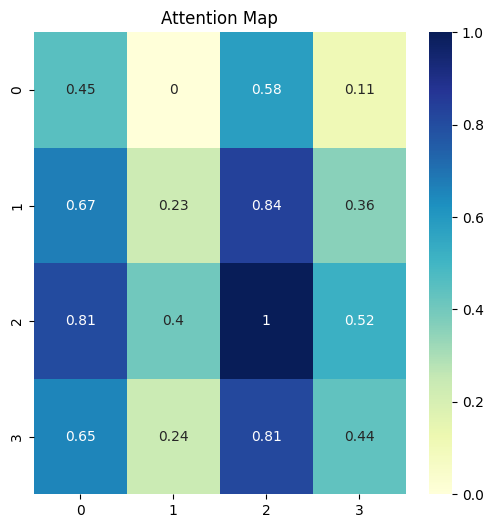

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.8953)

tensor(0.3530, grad_fn=<DivBackward1>)


 60%|██████    | 18/30 [2:31:37<1:35:49, 479.10s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9999, 0.9136, 0.9797, 0.6734],
         [0.8918, 0.9978, 0.9589, 0.3852],
         [0.9923, 0.9595, 0.9979, 0.5903],
         [0.6549, 0.8787, 0.7654, 0.1899]],

        [[0.9974, 0.7814, 0.9961, 0.7942],
         [0.7898, 0.3436, 0.6981, 0.9968],
         [0.9611, 0.5723, 0.9067, 0.9486],
         [0.7531, 0.9998, 0.8391, 0.3967]],

        [[0.9920, 0.9986, 0.8802, 0.9938],
         [1.0000, 0.9850, 0.9290, 0.9999],
         [0.8980, 0.9602, 0.7012, 0.9043],
         [0.9896, 0.9491, 0.9730, 0.9873]],

        ...,

        [[0.5983, 0.7342, 0.7010, 0.7415],
         [0.8027, 0.9095, 0.8859, 0.9145],
         [0.9758, 0.9042, 0.9260, 0.8990],
         [0.9844, 0.9988, 1.0000, 0.9980]],

        [[0.9998, 0.9339, 0.9874, 0.9607],
         [0.9082, 0.7319, 0.8455, 0.9907],
         [0.7125, 0.8945, 0.7919, 0.5309],
         [0.9099, 0.7344, 0.8477, 0.9913]],

        [[0.9956, 0.9497, 0.9874, 0.9804],
         [0.9746, 0.8136, 0.9870, 0.9926],
         [1.0000, 0.915

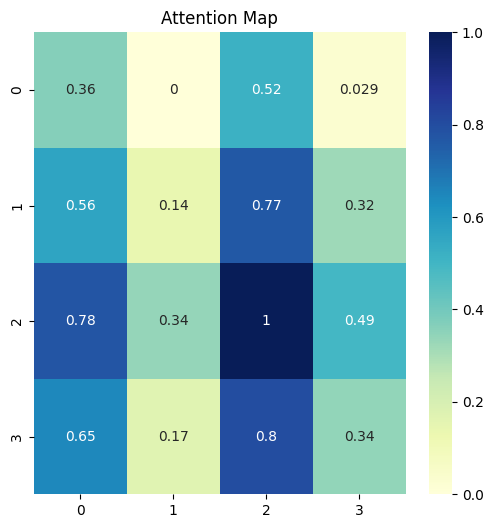

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9013)

tensor(0.3275, grad_fn=<DivBackward1>)


 63%|██████▎   | 19/30 [2:39:14<1:26:35, 472.34s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9288, 0.9999, 0.9753, 0.6564],
         [0.9766, 0.9882, 0.9984, 0.7543],
         [0.9952, 0.9632, 0.9981, 0.8193],
         [0.7563, 0.9318, 0.8417, 0.4403]],

        [[0.9974, 0.8676, 1.0000, 0.7613],
         [0.9489, 0.9906, 0.9252, 0.5256],
         [0.8239, 0.5560, 0.8587, 0.9825],
         [0.7167, 0.4423, 0.7572, 1.0000]],

        [[0.9994, 0.9899, 0.9356, 0.9943],
         [0.9797, 0.9533, 0.9806, 0.9633],
         [0.5866, 0.6511, 0.3578, 0.6295],
         [0.9865, 0.9983, 0.8521, 0.9956]],

        ...,

        [[0.5933, 0.5861, 0.7028, 0.7768],
         [0.9881, 0.9863, 0.9996, 0.9878],
         [0.9964, 0.9954, 0.9953, 0.9747],
         [0.9870, 0.9851, 0.9998, 0.9889]],

        [[0.9988, 0.9803, 0.9964, 0.8213],
         [0.8989, 0.8290, 0.9477, 0.9772],
         [0.8885, 0.9452, 0.8250, 0.5086],
         [0.9307, 0.8691, 0.9704, 0.9567]],

        [[0.9597, 0.9828, 0.9703, 0.9349],
         [0.9475, 0.9896, 0.9596, 0.9200],
         [0.9944, 0.934

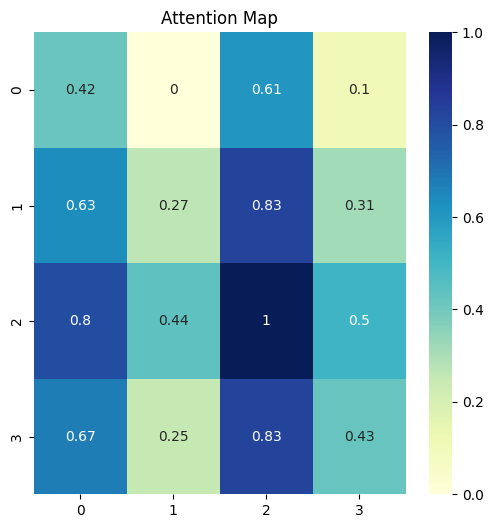

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9102)

tensor(0.3089, grad_fn=<DivBackward1>)


 67%|██████▋   | 20/30 [2:46:47<1:17:44, 466.42s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9716, 0.9962, 0.9642, 0.8107],
         [0.9999, 0.9866, 0.9998, 0.6674],
         [0.9980, 0.9960, 0.9957, 0.7116],
         [0.8456, 0.9130, 0.8305, 0.9535]],

        [[0.9980, 0.7823, 0.9998, 0.8073],
         [0.8861, 0.5290, 0.9201, 0.9747],
         [0.9416, 0.9589, 0.9115, 0.5670],
         [0.7537, 0.3813, 0.7998, 0.9994]],

        [[0.9984, 0.9949, 0.9999, 0.9959],
         [0.9880, 0.9802, 0.9962, 0.9822],
         [0.8391, 0.8166, 0.8719, 0.8220],
         [0.9989, 1.0000, 0.9935, 0.9999]],

        ...,

        [[0.9433, 0.7673, 0.7394, 0.7983],
         [0.8487, 0.9827, 0.9906, 0.9708],
         [0.7949, 0.9585, 0.9711, 0.9413],
         [0.9510, 0.9976, 0.9930, 0.9999]],

        [[0.9999, 0.9383, 0.9867, 0.9572],
         [0.9201, 0.7392, 0.8430, 0.9923],
         [0.7420, 0.5210, 0.6375, 0.8872],
         [0.9835, 0.9827, 1.0000, 0.8973]],

        [[0.9481, 0.9738, 0.9712, 0.9928],
         [0.9766, 0.7411, 0.9554, 0.9141],
         [0.9998, 0.865

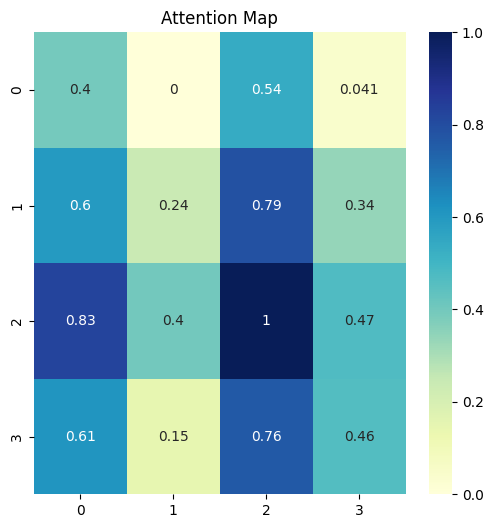

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9146)

tensor(0.2958, grad_fn=<DivBackward1>)


 70%|███████   | 21/30 [2:54:15<1:09:09, 461.10s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9269, 0.9132, 0.9744, 0.6406],
         [0.9987, 0.9999, 0.9777, 0.3837],
         [0.9655, 0.9556, 0.9947, 0.5650],
         [0.9045, 0.9188, 0.8304, 0.2046]],

        [[0.9976, 0.8696, 0.9914, 0.7974],
         [0.9778, 0.7208, 0.9186, 0.6347],
         [0.8909, 0.9932, 0.9614, 0.9665],
         [0.7866, 0.9955, 0.8857, 0.9988]],

        [[0.9897, 0.9900, 0.9712, 0.9935],
         [0.9716, 0.9721, 0.9445, 0.9782],
         [0.5681, 0.5693, 0.5094, 0.5861],
         [0.9907, 0.9910, 0.9728, 0.9943]],

        ...,

        [[0.5508, 0.7949, 0.7435, 0.7904],
         [0.9928, 0.9576, 0.9798, 0.9598],
         [0.7692, 0.9531, 0.9223, 0.9507],
         [0.9502, 0.9955, 1.0000, 0.9963]],

        [[0.9999, 0.9357, 0.9912, 0.9845],
         [0.9219, 0.9985, 0.9599, 0.8375],
         [0.6883, 0.4789, 0.6177, 0.7978],
         [0.9828, 0.8664, 0.9549, 1.0000]],

        [[0.9666, 0.7604, 0.9798, 0.9972],
         [0.9790, 0.7905, 0.9892, 0.9998],
         [0.9928, 0.835

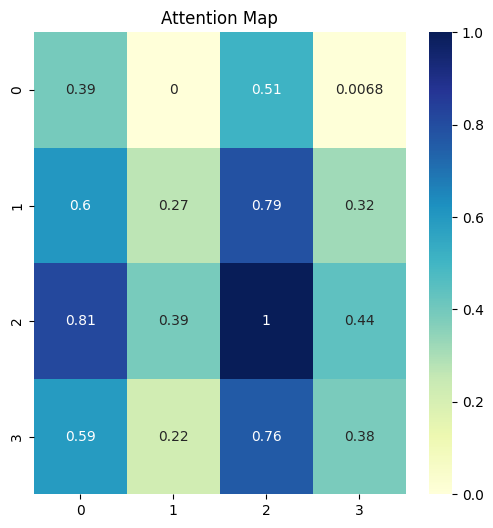

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9139)

tensor(0.2874, grad_fn=<DivBackward1>)


 73%|███████▎  | 22/30 [3:02:24<1:02:35, 469.41s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9142, 0.9166, 0.9726, 0.3905],
         [0.9116, 0.9141, 0.9711, 0.3870],
         [0.9916, 0.9924, 0.9983, 0.5593],
         [0.8762, 0.8734, 0.7815, 0.9102]],

        [[0.9993, 0.8676, 1.0000, 0.7712],
         [0.9981, 0.9099, 0.9956, 0.8240],
         [0.9038, 0.6398, 0.9170, 0.5264],
         [0.8380, 0.9951, 0.8210, 0.9961]],

        [[0.9861, 0.9948, 0.9571, 0.9957],
         [0.9989, 0.9998, 0.9171, 0.9996],
         [0.7921, 0.8266, 0.9762, 0.8313],
         [0.9980, 1.0000, 0.9233, 0.9999]],

        ...,

        [[0.8353, 0.8165, 0.8410, 0.8456],
         [0.8160, 0.8349, 0.8101, 0.8051],
         [0.8291, 0.8100, 0.8348, 0.8395],
         [0.9995, 0.9976, 0.9998, 0.9999]],

        [[0.9999, 0.9355, 0.9944, 0.9999],
         [0.9113, 0.9988, 0.8736, 0.9133],
         [0.7420, 0.5135, 0.7917, 0.7391],
         [0.9935, 0.8843, 0.9997, 0.9929]],

        [[0.9966, 0.9413, 0.9919, 0.9871],
         [0.9428, 0.7414, 0.9565, 0.9656],
         [0.9948, 0.867

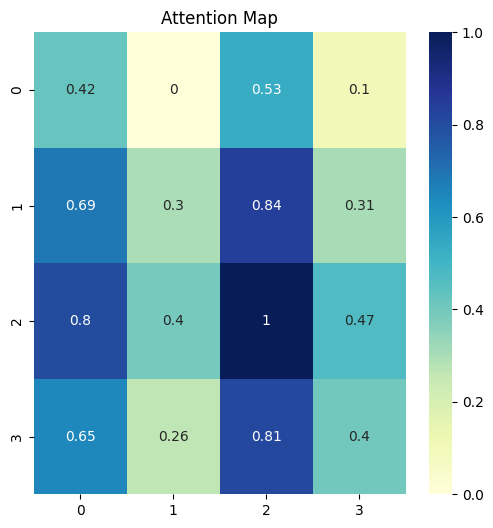

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9146)

tensor(0.2807, grad_fn=<DivBackward1>)


 77%|███████▋  | 23/30 [3:09:55<54:07, 463.97s/it]  /home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9989, 0.9999, 0.9779, 0.6720],
         [0.9980, 0.9995, 0.9747, 0.6630],
         [0.9970, 0.9940, 0.9963, 0.7456],
         [0.6501, 0.6306, 0.7465, 0.9965]],

        [[0.9975, 0.8646, 1.0000, 0.7926],
         [0.8501, 0.5827, 0.8786, 0.4974],
         [0.9684, 0.9770, 0.9517, 0.9379],
         [0.7509, 0.4715, 0.7850, 0.3919]],

        [[0.9802, 0.9742, 0.9691, 0.9929],
         [0.9997, 0.9985, 0.9971, 0.9985],
         [0.7113, 0.7279, 0.7407, 0.6632],
         [0.9891, 0.9845, 0.9804, 0.9977]],

        ...,

        [[0.9080, 0.7702, 0.8579, 0.7108],
         [0.9993, 0.9699, 0.9969, 0.9403],
         [0.9028, 0.7631, 0.8518, 0.7033],
         [0.9835, 0.9949, 0.9977, 0.9793]],

        [[0.9995, 0.9823, 0.9978, 0.9597],
         [0.9776, 0.9985, 0.9843, 0.9991],
         [0.8302, 0.7447, 0.8121, 0.6876],
         [0.9982, 0.9953, 0.9997, 0.9812]],

        [[0.9992, 0.9423, 0.9915, 0.9985],
         [0.8957, 0.7412, 0.9565, 0.9321],
         [0.9743, 0.867

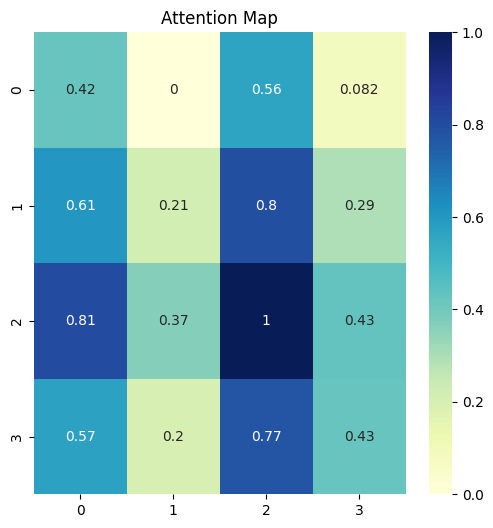

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9154)

tensor(0.2712, grad_fn=<DivBackward1>)


 80%|████████  | 24/30 [3:17:16<45:42, 457.01s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9256, 0.9171, 0.9761, 0.6720],
         [0.9162, 0.9073, 0.9704, 0.6870],
         [0.9563, 0.9496, 0.9921, 0.6149],
         [0.7028, 0.6893, 0.8007, 0.9057]],

        [[0.9996, 0.9218, 1.0000, 0.7997],
         [0.8363, 0.9752, 0.8229, 0.9992],
         [0.9233, 0.7415, 0.9328, 0.5833],
         [0.7884, 0.9514, 0.7740, 0.9987]],

        [[0.9864, 0.9983, 0.9412, 0.9911],
         [0.9882, 0.9309, 0.8001, 0.9828],
         [0.8699, 0.9550, 0.9999, 0.8843],
         [0.9908, 0.9961, 0.9310, 0.9946]],

        ...,

        [[0.7928, 0.5856, 0.6958, 0.6519],
         [0.9327, 0.9998, 0.9796, 0.9916],
         [0.9985, 0.9565, 0.9934, 0.9823],
         [0.9753, 0.9916, 0.9986, 0.9998]],

        [[1.0000, 0.9824, 0.9960, 0.8757],
         [0.9716, 0.9146, 0.9490, 0.7553],
         [0.8679, 0.9407, 0.9043, 0.9997],
         [0.9868, 0.9998, 0.9969, 0.9418]],

        [[0.9975, 0.8199, 0.9918, 0.9807],
         [0.9933, 0.8430, 0.9850, 0.9708],
         [1.0000, 0.783

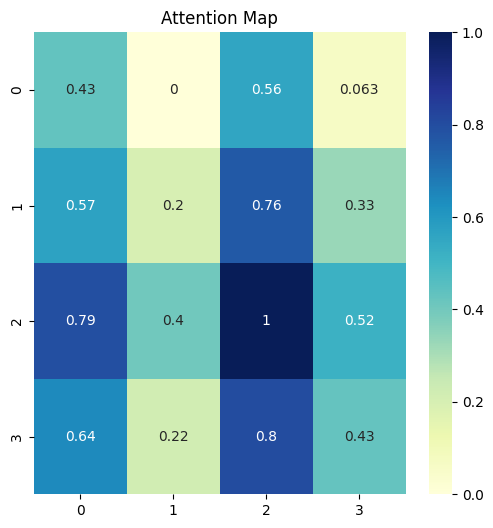

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9198)

tensor(0.2594, grad_fn=<DivBackward1>)


 83%|████████▎ | 25/30 [3:24:32<37:32, 450.49s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9994, 0.8967, 0.9627, 0.6062],
         [0.9540, 0.9923, 0.9978, 0.8051],
         [0.9511, 0.9934, 0.9971, 0.8101],
         [0.6813, 0.9060, 0.8171, 0.9960]],

        [[0.9995, 0.7764, 0.9958, 0.8591],
         [0.9478, 0.6021, 0.9793, 0.6986],
         [0.9033, 0.5277, 0.9476, 0.6245],
         [0.8161, 0.9991, 0.7489, 0.9931]],

        [[0.9996, 0.9999, 0.9396, 0.9935],
         [0.9983, 0.9948, 0.9649, 0.9802],
         [0.7048, 0.7304, 0.5088, 0.7852],
         [0.9813, 0.9887, 0.8734, 0.9986]],

        ...,

        [[0.9327, 0.7276, 0.8867, 0.7699],
         [0.9999, 0.9204, 0.9950, 0.9461],
         [0.8270, 0.9817, 0.8828, 0.9651],
         [0.9884, 0.9638, 0.9994, 0.9807]],

        [[1.0000, 0.9362, 0.9975, 0.9732],
         [0.9554, 0.9982, 0.9736, 0.9976],
         [0.7298, 0.9113, 0.7700, 0.8543],
         [0.9448, 0.9997, 0.9652, 0.9946]],

        [[0.9646, 0.8766, 0.9994, 0.9877],
         [0.9984, 0.9555, 0.9844, 0.9985],
         [0.9588, 0.866

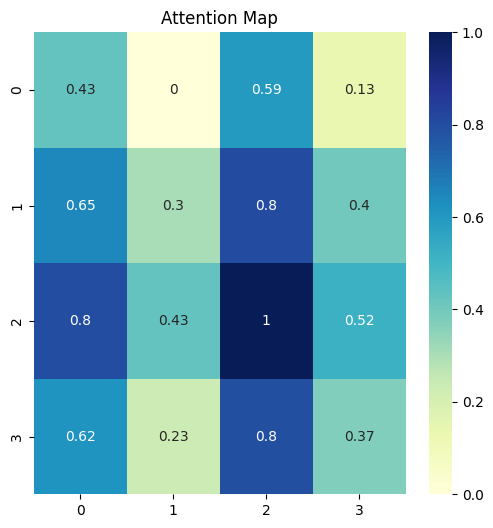

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9220)

tensor(0.2468, grad_fn=<DivBackward1>)


 87%|████████▋ | 26/30 [3:31:45<29:42, 445.53s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8956, 0.9969, 0.9664, 0.9253],
         [0.9921, 0.9657, 0.9967, 0.7619],
         [0.9620, 0.9938, 0.9975, 0.8426],
         [0.9116, 0.7143, 0.8157, 0.4331]],

        [[0.9993, 0.7751, 0.9893, 0.7616],
         [0.8917, 0.9809, 0.8019, 0.4546],
         [0.9119, 0.9703, 0.8277, 0.4831],
         [0.8318, 0.9977, 0.7305, 0.3839]],

        [[0.9969, 0.9855, 0.9989, 0.9978],
         [0.9736, 0.9903, 0.9384, 0.9707],
         [0.6474, 0.5919, 0.7220, 0.6550],
         [0.9994, 0.9919, 0.9960, 0.9997]],

        ...,

        [[0.8462, 0.8201, 0.8489, 0.7977],
         [0.9076, 0.8859, 0.9098, 0.8668],
         [0.9902, 0.9961, 0.9894, 0.9989],
         [0.9996, 0.9998, 0.9994, 0.9979]],

        [[0.9999, 0.9389, 0.9933, 0.9729],
         [0.9207, 0.7386, 0.8648, 0.9823],
         [0.7291, 0.5061, 0.6505, 0.8464],
         [0.9987, 0.9495, 0.9966, 0.9648]],

        [[0.9844, 0.9559, 0.9848, 0.9989],
         [0.9891, 0.9472, 0.9894, 0.9999],
         [0.9980, 0.917

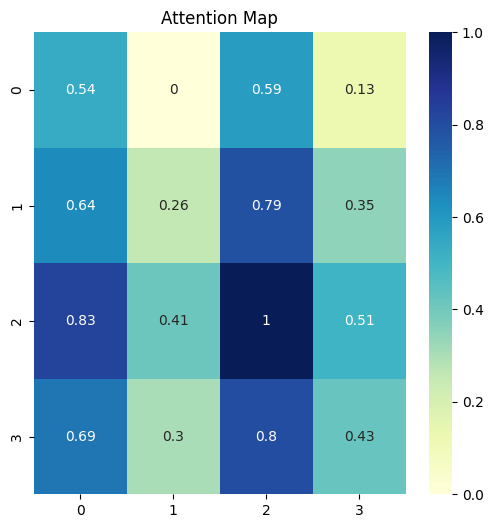

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9243)

tensor(0.2363, grad_fn=<DivBackward1>)


 90%|█████████ | 27/30 [3:39:04<22:09, 443.30s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9948, 0.9231, 0.9776, 0.6759],
         [0.9590, 1.0000, 0.9843, 0.8851],
         [0.9995, 0.9651, 0.9968, 0.7540],
         [0.8639, 0.7033, 0.8085, 0.4162]],

        [[0.9976, 0.8641, 0.9850, 0.7716],
         [0.9992, 0.8101, 0.9608, 0.8294],
         [0.9211, 0.9793, 0.9870, 0.5725],
         [0.8763, 0.5318, 0.7506, 0.9907]],

        [[0.9969, 0.9937, 0.9283, 0.9944],
         [0.9995, 0.9753, 0.8837, 1.0000],
         [0.6072, 0.4926, 0.3427, 0.6238],
         [0.9983, 0.9693, 0.8721, 0.9995]],

        ...,

        [[0.7483, 0.8591, 0.8787, 0.7825],
         [0.9728, 0.9056, 0.8878, 0.9571],
         [0.9051, 0.8058, 0.7829, 0.8790],
         [0.9908, 0.9972, 0.9931, 0.9972]],

        [[1.0000, 0.9817, 0.9960, 0.9744],
         [0.9554, 0.9947, 0.9287, 0.9977],
         [0.7297, 0.8380, 0.6810, 0.8553],
         [0.9992, 0.9874, 0.9925, 0.9812]],

        [[0.9977, 0.7091, 1.0000, 0.9909],
         [0.9958, 0.6135, 0.9876, 0.9997],
         [0.9918, 0.744

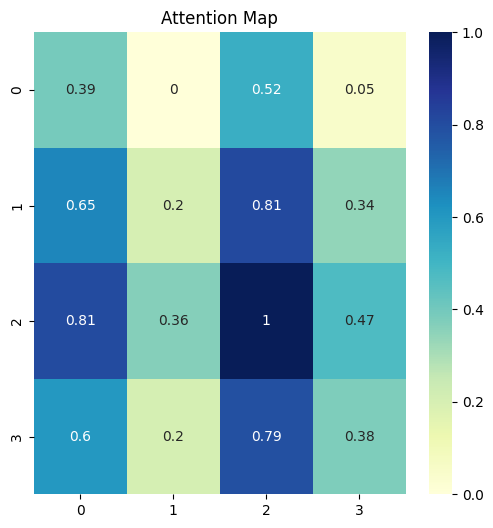

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9280)

tensor(0.2277, grad_fn=<DivBackward1>)


 93%|█████████▎| 28/30 [3:46:21<14:42, 441.39s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9700, 0.8934, 0.9656, 0.8201],
         [0.9563, 0.9975, 0.9612, 0.5010],
         [0.9903, 0.9961, 0.9926, 0.5966],
         [0.8250, 0.6980, 0.8160, 0.9676]],

        [[0.9980, 0.9168, 0.9956, 0.7910],
         [0.9060, 0.6524, 0.8347, 0.4913],
         [0.9251, 0.6822, 0.8589, 0.5206],
         [0.7609, 0.9669, 0.8440, 1.0000]],

        [[0.9996, 0.9980, 0.9997, 0.9951],
         [0.9934, 0.9888, 0.9980, 0.9829],
         [0.7522, 0.7717, 0.7223, 0.7912],
         [1.0000, 0.9991, 0.9990, 0.9969]],

        ...,

        [[0.7588, 0.8744, 0.7913, 0.7196],
         [0.9100, 0.9783, 0.9319, 0.8813],
         [0.9669, 0.9994, 0.9800, 0.9477],
         [0.9866, 0.9982, 0.9944, 0.9733]],

        [[1.0000, 0.9373, 0.9894, 0.9991],
         [0.9172, 0.9986, 0.9649, 0.9015],
         [0.8218, 0.9657, 0.8919, 0.8009],
         [0.9922, 0.9723, 0.9997, 0.9865]],

        [[0.9909, 0.9553, 0.9850, 0.9695],
         [0.9838, 0.9676, 0.9762, 0.9576],
         [0.9999, 0.915

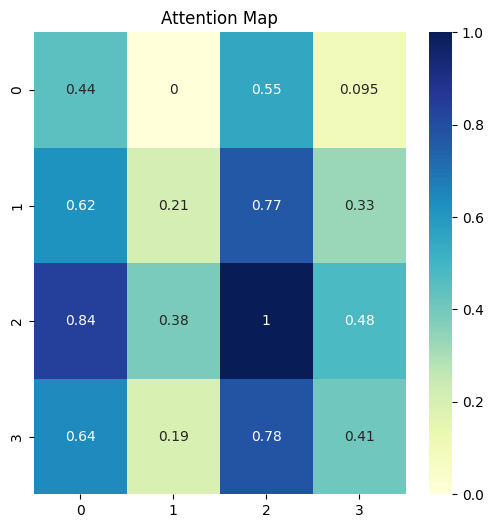

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9302)

tensor(0.2197, grad_fn=<DivBackward1>)


 97%|█████████▋| 29/30 [3:53:37<07:20, 440.05s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9996, 0.9167, 0.9765, 0.5391],
         [0.9763, 0.9854, 0.9996, 0.6874],
         [0.9968, 0.9530, 0.9938, 0.6035],
         [0.7518, 0.9354, 0.8528, 0.9472]],

        [[0.9976, 0.8594, 0.9992, 0.7775],
         [0.9991, 0.9080, 0.9887, 0.7141],
         [0.9924, 0.9381, 0.9732, 0.6654],
         [0.8344, 0.9927, 0.7766, 0.3855]],

        [[0.9932, 0.9993, 0.9777, 0.9962],
         [1.0000, 0.9971, 0.9952, 0.9997],
         [0.6658, 0.6178, 0.7222, 0.6480],
         [0.9955, 0.9999, 0.9821, 0.9978]],

        ...,

        [[0.7302, 0.7490, 0.7241, 0.7644],
         [0.9165, 0.9286, 0.9124, 0.9381],
         [0.9573, 0.9661, 0.9543, 0.9727],
         [0.9964, 0.9987, 0.9955, 0.9997]],

        [[0.9991, 0.9800, 0.9923, 0.9719],
         [0.9467, 0.8867, 0.9865, 0.8698],
         [0.7454, 0.8316, 0.6473, 0.8503],
         [0.9958, 0.9977, 0.9674, 0.9944]],

        [[0.9996, 0.9692, 0.9997, 0.9943],
         [0.9996, 0.9691, 0.9997, 0.9944],
         [0.9986, 0.985

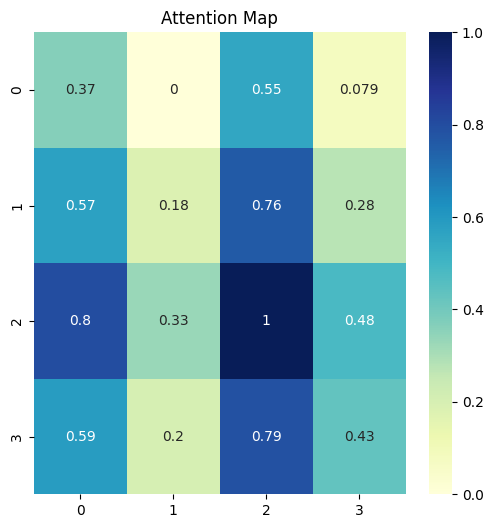

tensor([1, 1, 4,  ..., 8, 6, 3])
tensor([1., 1., 4.,  ..., 8., 6., 3.], dtype=torch.float64)

Accuracy: tensor(0.9362)

tensor(0.2106, grad_fn=<DivBackward1>)


100%|██████████| 30/30 [4:00:57<00:00, 481.90s/it]


In [22]:
for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9913, 0.9702, 0.9520, 0.9779],
         [0.9238, 0.8773, 0.8454, 0.8924],
         [0.9992, 0.9882, 0.9758, 0.9929],
         [0.9980, 0.9987, 0.9930, 0.9999]],

        [[0.9030, 0.9904, 0.9604, 0.9765],
         [0.8821, 0.9825, 0.9460, 0.9650],
         [0.9742, 0.9965, 0.9981, 1.0000],
         [0.9997, 0.9590, 0.9897, 0.9781]],

        [[0.8935, 0.9618, 0.8922, 0.6568],
         [0.9171, 0.8295, 0.9184, 0.9996],
         [0.9965, 0.9938, 0.9962, 0.8705],
         [0.9534, 0.9936, 0.9525, 0.7540]],

        ...,

        [[0.9433, 0.6862, 0.9071, 0.8847],
         [0.9862, 0.9374, 0.9978, 0.9999],
         [0.9998, 0.8792, 0.9967, 0.9910],
         [0.9937, 0.9181, 0.9999, 0.9992]],

        [[0.9997, 0.9999, 0.9651, 0.9988],
         [0.9981, 0.9985, 0.9742, 0.9962],
         [0.9713, 0.9730, 0.9988, 0.9651],
         [0.9570, 0.9550, 0.8416, 0.9639]],

        [[1.0000, 0.9983, 0.9952, 0.9924],
         [0.9596, 0.9442, 0.9834, 0.9876],
         [0.9922, 0.984

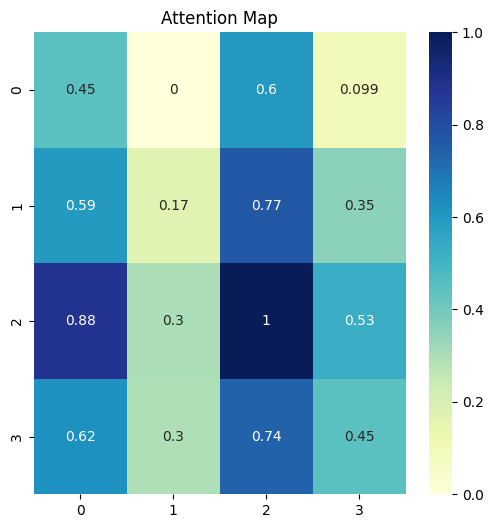

tensor([0, 3, 1, 8, 2, 2, 6, 5, 8, 8, 5, 6, 6, 9, 0, 0, 8, 4, 3, 0, 9, 9, 1, 9,
        3, 0, 7, 3, 3, 0, 7, 1, 9, 9, 8, 1, 9, 1, 7, 1, 6, 2, 7, 0, 5, 9, 5, 6,
        7, 0, 4, 5, 1, 0, 5, 6, 7, 2, 9, 6, 5, 4, 6, 0, 6, 4, 4, 8, 6, 0, 4, 5,
        3, 6, 1, 2, 7, 5, 0, 0, 2, 8, 5, 3, 7, 3, 5, 2, 1, 5, 8, 1, 1, 2, 9, 8,
        4, 6, 5, 2, 5, 9, 6, 3, 4, 8, 0, 8, 3, 2, 1, 3, 9, 3, 2, 8, 5, 1, 4, 9,
        0, 5, 5, 7, 3, 8, 7, 4, 4, 1, 7, 6, 0, 9, 4, 8, 9, 9, 2, 7, 4, 2, 8, 6,
        1, 1, 3, 5, 5, 8, 8, 0, 2, 4, 5, 3, 4, 8, 6, 1, 7, 6, 7, 5, 1, 9, 8, 4,
        1, 8, 2, 4, 4, 9, 7, 4, 5, 1, 3, 7, 9, 7, 3, 4, 6, 4, 8, 8, 9, 3, 2, 4,
        2, 7, 1, 6, 2, 2, 1, 5, 1, 1, 1, 0, 6, 3, 9, 2, 6, 4, 7, 1, 7, 5, 2, 3,
        6, 0, 0, 6, 5, 8, 7, 5, 1, 6, 3, 3, 8, 7, 7, 9, 9, 7, 6, 3, 7, 6, 3, 8,
        7, 6, 7, 0, 7, 8, 5, 3, 6, 3, 0, 4, 6, 6, 5, 0, 1, 0, 3, 6, 1, 8, 8, 6,
        3, 5, 3, 2, 5, 1, 9, 4, 5, 1, 4, 7, 2, 5, 7, 5, 5, 2, 5, 4, 8, 6, 1, 7,
        1, 6, 6, 9, 1, 5, 6, 8, 0, 3, 6,

In [23]:
from sklearn.metrics import roc_auc_score

# Convert the predictions to probabilities (if they are logits)
X_tensor = torch.tensor(X_test)
predictions = model(X_tensor.float())

# Convert labels to one-hot encoding
label = torch.tensor(y_test)

# Calculate loss
loss = criterion(predictions, label.float())

# Calculate accuracy (multi-class)
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC (multi-class)
# Flatten the arrays for roc_auc_score (if needed)
probs_np = predictions.detach().numpy()  # Convert to numpy
labels_np = label.numpy()

# Calculate AUROC using "micro" averaging (which considers all classes equally)
auroc = roc_auc_score(labels_np, probs_np, multi_class="ovr")

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------